# Análise de Dados Alimentares

Neste notebook, vamos realizar uma análise dos dados nutricionais de alimentos. O objetivo é entender a relação entre os ingredientes e sua classificação como saudável ou não saudável.

## Passos do processo:
1. Carregar o arquivo de dados.
2. Pré-processar os dados.
3. Treinar o modelo de Machine Learning.


# 1 - Importação das bibliotecas

In [28]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Métricas do resultado do modelo
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

# Treino e Teste
from sklearn.model_selection import train_test_split

# Otimização de parametros
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold

# tratamento de dados
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

# salvar modelo
import joblib

# 2 - Importação base de dados

In [29]:
# Grava o arquivo json na variável df para manipulação
df = pd.read_json("../data/raw/dados_alimentos.json")

# visualiza o json em formato csv
df.head()

,ingredientes,calorias,carboidratos,proteinas,gorduras,classificacao
0,"[arroz branco, feijão carioca, peito de frango...",480,65,35,8,1
1,"[hambúrguer, pão branco, queijo processado, mo...",850,80,30,50,0
2,"[salmão assado, quinoa, brócolis cozido no vapor]",520,45,40,25,1
3,"[pizza de calabresa, refrigerante]",1100,120,40,60,0
4,"[iogurte natural, frutas vermelhas, granola]",350,40,15,12,1


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ingredientes   51 non-null     object
 1   calorias       51 non-null     int64 
 2   carboidratos   51 non-null     int64 
 3   proteinas      51 non-null     int64 
 4   gorduras       51 non-null     int64 
 5   classificacao  51 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 2.5+ KB


In [31]:
df.describe()

,calorias,carboidratos,proteinas,gorduras,classificacao
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,552.745098,56.372549,24.431373,27.450980,0.509804
std,266.368755,25.180120,13.716056,17.501216,0.504878
min,50.000000,10.000000,0.000000,0.000000,0.000000
25%,350.000000,40.000000,15.000000,15.000000,0.000000
50%,480.000000,55.000000,25.000000,20.000000,1.000000
75%,700.000000,70.000000,35.000000,37.500000,1.000000
max,1200.000000,120.000000,60.000000,70.000000,1.000000


# 3 - Tratando os dados

## 3.1 Verificando valores nulos e NA

In [32]:
# Verifica se há valores nulos e faz uma soma deles
# no caso não houve valores nulos
df.isnull().sum()

ingredientes     0
calorias         0
carboidratos     0
proteinas        0
gorduras         0
classificacao    0
dtype: int64

In [33]:
# Verifica se há valores NA e faz uma soma deles
# no caso não houve valres nulos
df.isna().sum()

ingredientes     0
calorias         0
carboidratos     0
proteinas        0
gorduras         0
classificacao    0
dtype: int64

## 3.2 Tratando valores categóricos para numéricos

In [34]:
# Converter a lista de ingredientes para strings separadas por espaço
df['ingredientes_str'] = df['ingredientes'].apply(lambda x: ' '.join(x))

# Inicializar o CountVectorizer
vectorizer = CountVectorizer()

# Ajustar o vetorizador aos ingredientes e transformar os dados
X_ingredients = vectorizer.fit_transform(df['ingredientes_str']).toarray()

# Criar um DataFrame com as novas features dos ingredientes
df_ingredients = pd.DataFrame(X_ingredients, columns=vectorizer.get_feature_names_out())

# Concatenar as novas features com o DataFrame original
df_processed = pd.concat([df.drop(['ingredientes', 'ingredientes_str'], axis=1), df_ingredients], axis=1)

df_processed.head()

,calorias,carboidratos,proteinas,gorduras,classificacao,abacate,abobrinha,abóbora,alface,alho,...,verdes,vermelhas,vermelho,vinagre,vinagrete,virgem,wrap,xarope,yakissoba,água
0,480,65,35,8,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,850,80,30,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,520,45,40,25,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1100,120,40,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,350,40,15,12,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


# 4 - Teste e Treino

In [35]:
# Dados explicativos
x = df_processed.drop(columns="classificacao")
x.head()

,calorias,carboidratos,proteinas,gorduras,abacate,abobrinha,abóbora,alface,alho,amendoim,...,verdes,vermelhas,vermelho,vinagre,vinagrete,virgem,wrap,xarope,yakissoba,água
0,480,65,35,8,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,850,80,30,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,520,45,40,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1100,120,40,60,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,350,40,15,12,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [36]:
# Dado alvo
y = df_processed["classificacao"]
y.value_counts()

classificacao
1    26
0    25
Name: count, dtype: int64

In [37]:
# Separação entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=0, test_size=0.3)

# 5 - Modelo de machine learning

<strong>Procurando o melhor modelo para depois fazer uma otimização em seus parâmetros<strong>

## 5.1 - Criando uma função para testar os modelos

In [38]:
def metrics (y_true, y_pred):
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    RocCurveDisplay.from_predictions(y_true, y_pred)

## 5.2 - RandomForestClassifier

In [39]:
modelo_random_forest = RandomForestClassifier(max_depth=15).fit(X_train, y_train)

predict = modelo_random_forest.predict(X_test)

### 5.2.1 - Métricas

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



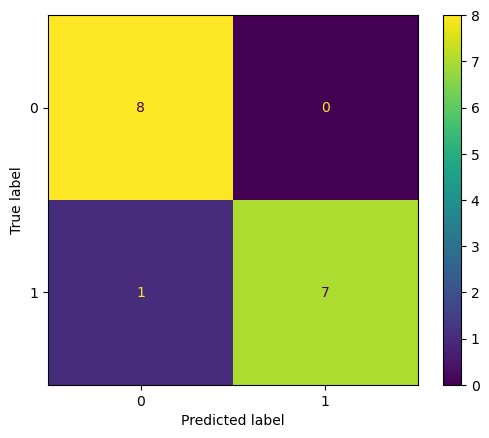

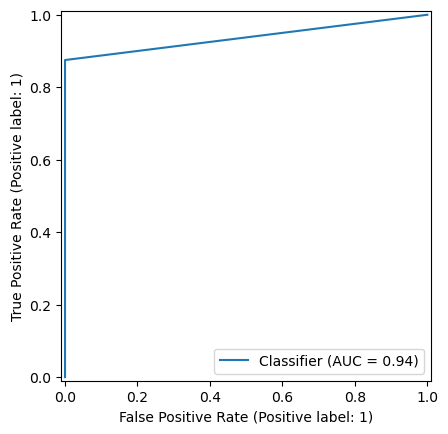

In [40]:
metrics(y_test, predict)

### 5.2.2 Cross_val_score no RandomForestClassifier

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
modelo = RandomForestClassifier(max_depth=15)

scores = cross_val_score(modelo, x, y, cv=kf)
print("Acurácias:", scores)
print("Média da acurácia:", scores.mean())

Acurácias: [0.72727273 1.         0.7        0.9        1.        ]
Média da acurácia: 0.8654545454545455


## 5.3 - SVC

In [42]:
modelo_SVC = SVC().fit(X_train, y_train)

predict = modelo_SVC.predict(X_test)

### 5.3.1 - Métricas

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



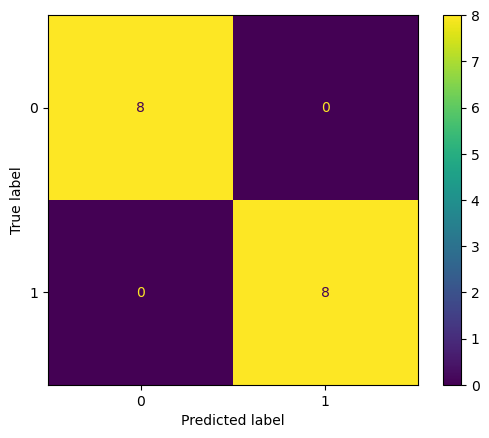

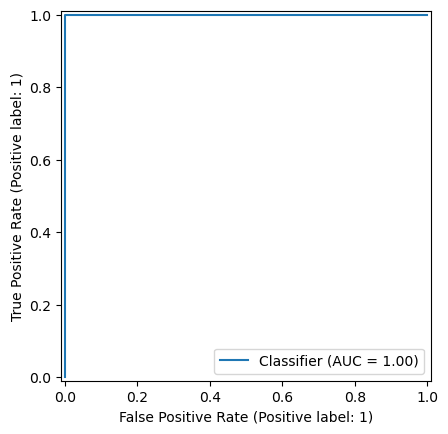

In [43]:
metrics(y_test, predict)

### 5.3.2 Cross_val_score no SVC

In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
modelo = SVC()

scores = cross_val_score(modelo, x, y, cv=kf)
print("Acurácias:", scores)
print("Média da acurácia:", scores.mean())

Acurácias: [0.81818182 0.9        0.8        0.9        1.        ]
Média da acurácia: 0.8836363636363636


## 5.4 - MLP

In [45]:
modelo_MLP = MLPClassifier().fit(X_train, y_train)

predict = modelo_MLP.predict(X_test)

C:\Users\yasmi\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 5.4.1 Métricas

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



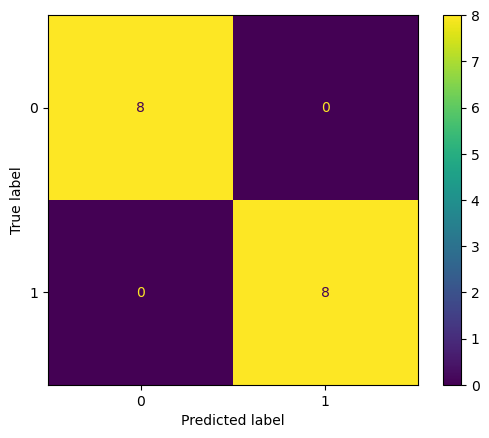

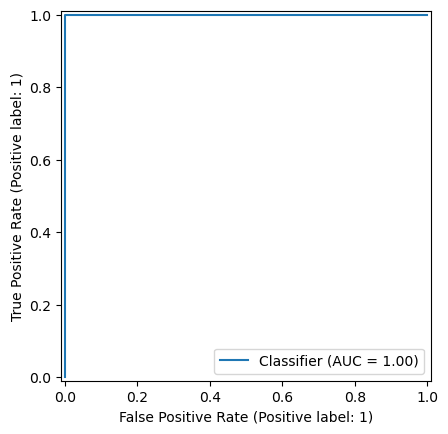

In [46]:
metrics(y_test, predict)

### 5.4.2 val_cross_score no MLP

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
modelo = MLPClassifier()

scores = cross_val_score(modelo, x, y, cv=kf)
print("Acurácias:", scores)
print("Média da acurácia:", scores.mean())

C:\Users\yasmi\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yasmi\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Acurácias: [1.  0.9 0.3 0.9 0.5]
Média da acurácia: 0.72


C:\Users\yasmi\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 6 - Otimizando parâmetros

In [48]:
# Parametros a serem testados
param_distributions = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [49]:
# Validação cruzada e busca
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [50]:
search = RandomizedSearchCV(
    modelo_random_forest,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 6. Ajuste
search.fit(x, y)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(max_depth=15), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [51]:
# Resultados
print("Melhores parâmetros:")
print(search.best_params_)

print("\nMelhor score (AUC):")
print(search.best_score_)

Melhores parâmetros:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

Melhor score (AUC):
0.9682539682539684


# 7 - Salvando modelo para API

In [52]:
best_model = search.best_estimator_

joblib.dump(best_model, "../app/models/best_model.pkl")
joblib.dump(vectorizer, "../app/utils/vectorizer.pkl")

['../app/utils/vectorizer.pkl']

In [53]:
joblib.load("../app/models/vectorizer.pkl")

CountVectorizer()